<a href="https://colab.research.google.com/github/choheeee22/Section2_Project/blob/main/Section2__%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

목차


1. 프로젝트 목적 소개

2. 프로젝트 진행 절차 (과정, 가설 및 평가지표) 

3. 데이터 소개 

4. 머신 러닝 분석 및 비교 


*   Linear Regression
*   Lasso Regression
*   Decision Tree Regression
*   Random Forest Regreesion
*   XGB Boosting Regreesion

*   Random Forest & XGB Boosting Hyper Parameter Tuning

5. 결론 및 시사점 







1. 프로젝트 목적 소개

배경: 공장의 라인 운영과 긴 원부자재 리드타임 고려해, 바이어 오더 수주 전 우리 회사의 부담으로 미리 오더를 예상해 자재 선발주 진행. 라인 블랭크 비용 및 바이어와의 관계 유지 감안 시 이와 같은 선발주는 피할 수 없는 상황.

문제 정의: 실제 오더 수주가 되지 않을 경우, 이에 소요된 원/부자재, 공장 운영 비용이 모두 회사 비용으로 책정 

현재 실행 방법: 이전 분기, 년도의 수주 받은 오더를 참고하여 스타일/색상등을 경험치로 예상 원부자재 발주 진행


제안 방법: 현재 예측 방법(수주 받은 오더 분석)에 바이어 세일즈 정보 및 미국 경제 지표에 대한 분석을 추가해 예측의 정확도를 높여 비용을 최소화

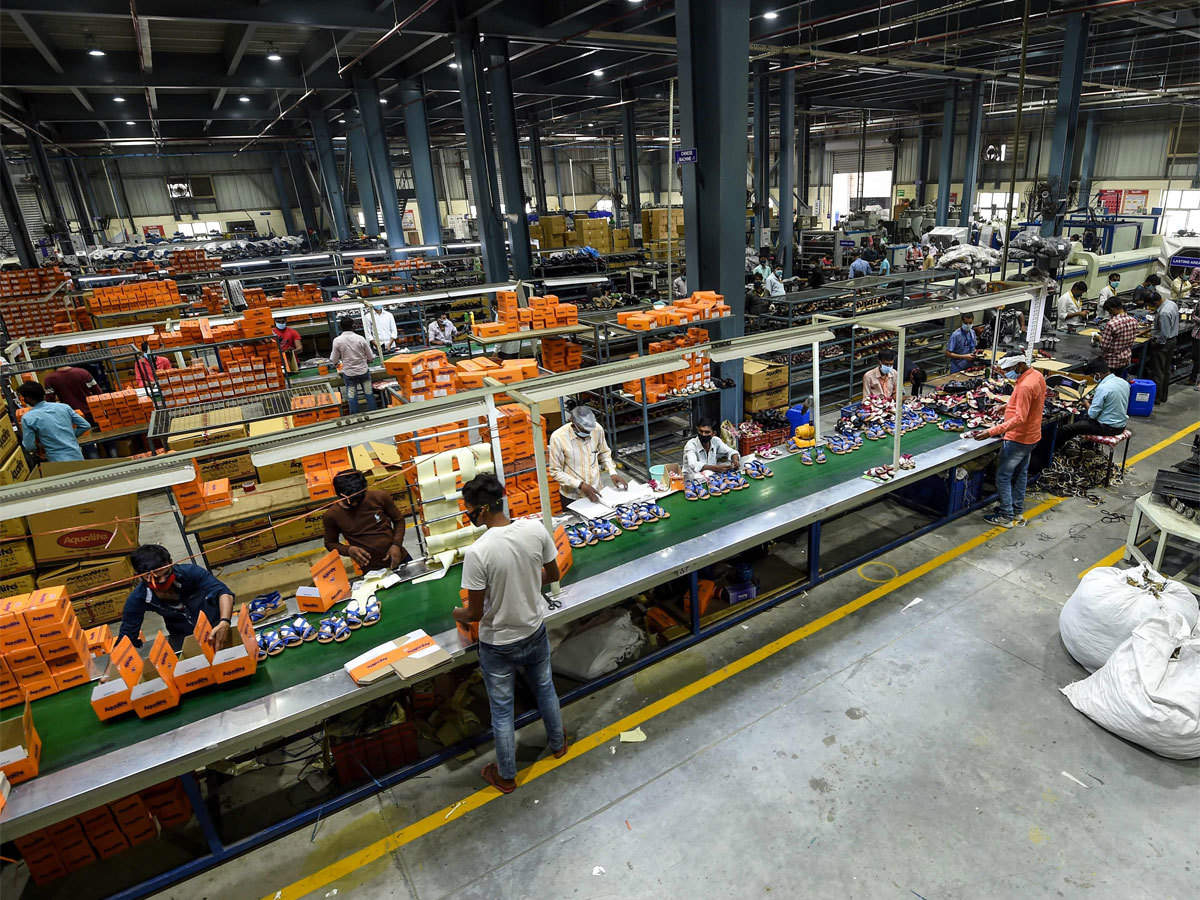


2. 프로젝트 진행 절차 (과정, 가설 및 평가지표) 

진행 절차 소개 

바이어 sales / 국가 경제지표 data를 시간에 따라 세 그룹으로 분류 (학습/검증/테스트).


학습 데이터를 통해 모델을 익히고, 검증 데이터로 어떤 모델이 우위를 평가 후, 최종 테스트 데이터 점수를 통해 미래의 세일즈 데이터를 얼마나 잘 예측하는지 평가


가설 소개 


가설1 boosting 기법이 성능이 제일 우수 할 것이다 (점수는 1점 만점에 0.8 이상 기대)


가설2 매 년 시기마다 비슷한 세일즈를 보일 것이다.

평가 지표

MAE (Mean Absolute Error) - 예상치와 실제값의 차이 절대값의 평균 

선정 이유:공휴일/ 피크시즌의 세일즈가 폭발 할 경우 이상치로 잡지 않고, 직관적이고 객관적인 평가가 가능하므로 선정 

R-Squared - 데이터에 대한 모델의 설명정도를 나타냄 (0~1)

선정 이유: 각 모델이 데이터를 얼마나 잘 설명하는 지 파악 위해 선정

3. 데이터 소개 

바이어: Walmart


데이터 기간: 2010-02-05 to 2012-11-01


변수: Store, Dept, 공휴일 유무(Super Bowl, Labor Day, Thanksgiving, Christmas), 기온, Markdown, CPI, 실업률, 유가 


In [3]:
#데이터 불러오기 
from google.colab import files
uploaded= files.upload()

Saving features.csv to features (2).csv
Saving stores.csv to stores (2).csv
Saving train.csv to train (2).csv


In [5]:
import pandas as pd 
features=pd.read_csv("features.csv")
stores=pd.read_csv("stores.csv")
train=pd.read_csv("train.csv")

In [6]:
#features 중 2012-11-01 (train 상 2012/10/26 이후 데이터 - over)/ features 에서 10/26 초과 데이터제거 -- features_2로 저장  (rows-6435)
features.Date.sort_values(ascending=False)
over=features[pd.to_datetime(features.Date)>pd.to_datetime("2012-10-26")]
over
features_2=features[~features['Date'].isin(over.Date)]
features_2.Date.sort_values(ascending=True)
features_2

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8146,45,2012-09-28,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False
8147,45,2012-10-05,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False
8148,45,2012-10-12,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False
8149,45,2012-10-19,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False


In [7]:
#data 합치기 -df (rows-421570)
df=train.merge(features_2,on=["Store","Date"])
df=df.merge(stores,on="Store")
df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221


In [9]:
#weekly sales ==0 값 확인하기 - 73개 제거 
df0=df[df.Weekly_Sales==0].index#73
df=df.loc[df.Weekly_Sales!=0]
df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221


In [10]:
#결측치 확인 - 아마 평균치로 대체 하면 될 거 같은데...결측치가 너무 많네...
#anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA. 
pd.DataFrame(df.isnull().sum(),columns=["결측치 개수"])

,결측치 개수
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday_x,0
Temperature,0
Fuel_Price,0
MarkDown1,270835
MarkDown2,310263
MarkDown3,284422


In [11]:
#중복치 확인 -없음
df.loc[df.duplicated()==True]

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size


In [13]:
#날짜 연/월/ 추출 &  date data type 변경 
import datetime
df['Date']=pd.to_datetime(df.Date)
df['Year']=pd.DatetimeIndex(df.Date).year
df['Month']=pd.DatetimeIndex(df.Date).month 
df['Week']=(df.Date.dt.isocalendar().week)*1.0 

df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

Weekly Sales by Store / Department/ Size/ Type

In [15]:
store_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(store_sales, 
             x=store_sales.index, 
             y=store_sales.values,  
             title="Average Sales - Per Store",
             labels={'x':'Stores', 'y':'Sales'},
             color_discrete_sequence=["#2E91E5"],template='simple_white')

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

In [16]:
Size_sales = df.groupby('Size')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(store_sales, 
             x=store_sales.index, 
             y=store_sales.values,  
             title="Average Sales - Per Size",
             labels={'x':'Size', 'y':'Sales'},
             color_discrete_sequence=["#2E91E5"], template='simple_white')

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

In [17]:
Dept_sales = df.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(store_sales, 
             x=store_sales.index, 
             y=store_sales.values,  
             title="Average Sales - Per Dept",
             labels={'x':'Dept', 'y':'Sales'},
             color_discrete_sequence=["#2E91E5"], template='simple_white')

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

Average Monthly Sales

In [18]:
sales2010 = df[(df.Year == 2010)].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2010 = pd.DataFrame(list(sales2010.items()), columns=['Month', 'AvgSales2010'])

sales2011 = df[df.Year == 2011].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2011 = pd.DataFrame(list(sales2011.items()), columns=['Month', 'AvgSales2011'])

sales2012 = df[df.Year == 2012].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2012 = pd.DataFrame(list(sales2012.items()), columns=['Month', 'AvgSales2012'])

monthly_df = df2010.merge(df2011, how='right', on='Month').merge(df2012, how='left', on='Month')

import plotly.graph_objs as go
# create trace1 
trace1 = go.Bar(
                x = df2010.Month,
                y = df2010.AvgSales2010,
                name = "AvgSales2010",marker_color='lightblue')
# create trace2 
trace2 = go.Bar(
                x = df2011.Month,
                y = df2011.AvgSales2011,
                name = "AvgSales2011",marker_color='deepskyblue')

# create trace3 
trace3 = go.Bar(
                x = df2012.Month,
                y = df2012.AvgSales2012,
                name = "AvgSales2012",marker_color="orangered")
data = [trace1, trace2, trace3]
layout = go.Layout(barmode = "group",
                   template='plotly_white',
                   xaxis_title="Month",
                   yaxis_title="Average Monthly Sales")



fig = go.Figure(data = data, layout = layout)
fig.update_xaxes( dtick=1)
fig.update_layout(title={
        'text': "Average Montly Sales by Year",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()


Average Week sales by year

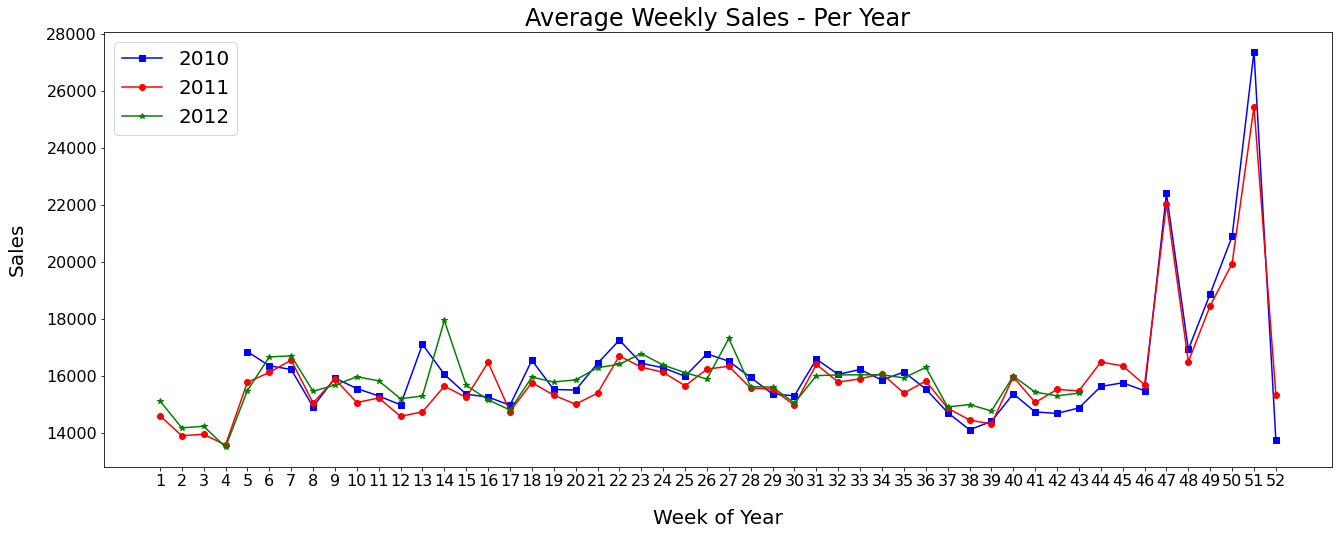

In [19]:
#weekly sales
import numpy as np
weekly_sales_2010 = df[df.Year==2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011 = df[df.Year==2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012 = df[df.Year==2012].groupby('Week')['Weekly_Sales'].mean()

plt.figure(figsize=(22,8))
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values, 's-b')
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values, 'o-r')
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values, '*-g')

plt.xticks(np.arange(1, 53, step=1), fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Week of Year', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20)

plt.title("Average Weekly Sales - Per Year", fontsize=24)
plt.legend(['2010', '2011', '2012'], fontsize=20);

4. 머신 러닝 분석 및 비교

데이터 분리 


In [20]:
df['Date']=pd.to_datetime(df['Date']).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
#데이터 분리 target=Weekly_Sales, 시계열 이므로 시간에 따라 분리하겠음 (2012-4-13)

import numpy as np 
df['Date'].sort_values(ascending=False).reset_index().iloc[84300] #20% 위치 확인 
con=pd.to_datetime(df['Date'])<pd.to_datetime("2012-04-13")
train=df.loc[con]
test=df.loc[~con]
test#85809
train#335761

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Week
0,1,1,1265328000000000000,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
1,1,2,1265328000000000000,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
2,1,3,1265328000000000000,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
3,1,4,1265328000000000000,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
4,1,5,1265328000000000000,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419614,45,93,1333670400000000000,2201.26,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0
419615,45,94,1333670400000000000,2853.87,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0
419616,45,95,1333670400000000000,52034.52,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0
419617,45,97,1333670400000000000,6628.22,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0


In [22]:
#VAL도 분리  #hold out
train['Date'].sort_values(ascending=False).reset_index().iloc[60000] #20% 위치 확인 
con2=pd.to_datetime(df['Date'])<pd.to_datetime("2011-11-18")
val=train.loc[~con2]
train=train.loc[con2]
train#273103 
val#62658

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Year,Month,Week
6659,1,1,1321574400000000000,19050.66,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False,A,151315,2011,11,46.0
6660,1,2,1321574400000000000,43997.78,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False,A,151315,2011,11,46.0
6661,1,3,1321574400000000000,10104.36,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False,A,151315,2011,11,46.0
6662,1,4,1321574400000000000,37656.58,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False,A,151315,2011,11,46.0
6663,1,5,1321574400000000000,27339.37,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False,A,151315,2011,11,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419614,45,93,1333670400000000000,2201.26,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0
419615,45,94,1333670400000000000,2853.87,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0
419616,45,95,1333670400000000000,52034.52,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0
419617,45,97,1333670400000000000,6628.22,False,49.73,3.996,13450.45,NaN,26.59,3363.54,3962.01,190.685171,8.567,False,B,118221,2012,4,14.0


In [23]:
#타겟 데이터 분리 
target='Weekly_Sales'
X_train=train.drop(target,axis=1)
y_train=train[target]
X_val=val.drop(target,axis=1)
y_val=val[target]
X_test=test.drop(target,axis=1)
y_test=test[target]
X_train, y_train
X_val, y_val
X_test, y_val

(        Store  Dept                 Date  ...  Year  Month  Week
 8174        1     1  1334275200000000000  ...  2012      4  15.0
 8175        1     2  1334275200000000000  ...  2012      4  15.0
 8176        1     3  1334275200000000000  ...  2012      4  15.0
 8177        1     4  1334275200000000000  ...  2012      4  15.0
 8178        1     5  1334275200000000000  ...  2012      4  15.0
 ...       ...   ...                  ...  ...   ...    ...   ...
 421565     45    93  1351209600000000000  ...  2012     10  43.0
 421566     45    94  1351209600000000000  ...  2012     10  43.0
 421567     45    95  1351209600000000000  ...  2012     10  43.0
 421568     45    97  1351209600000000000  ...  2012     10  43.0
 421569     45    98  1351209600000000000  ...  2012     10  43.0
 
 [85796 rows x 19 columns], 6659      19050.66
 6660      43997.78
 6661      10104.36
 6662      37656.58
 6663      27339.37
             ...   
 419614     2201.26
 419615     2853.87
 419616    52034.52

In [81]:
#Base 라인 잡기 - weekly sales 평균치 
Base=y_train.mean()
Base
y_base_pred=[Base]*len(y_train)
y_val_base_pred=[Base]*len(y_val)
y_test_base_pred=[Base]*len(y_test)
print("기준모델 스코어")
print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_base_pred)), print("R2:",r2_score(y_train,y_base_pred))
print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_base_pred)), print("R2:",r2_score(y_val,y_val_base_pred))
print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_base_pred)), print("R2:",r2_score(y_test,y_test_base_pred))

기준모델 스코어
훈련데이터
MAE: 14990.211049677679
R2: 1.1102230246251565e-16
검증데이터
MAE: 15810.859217688254
R2: -0.00112175471867193
테스트데이터
MAE: 15043.358183914726
R2: -1.924197210478873e-05


(None, None)

In [25]:
#import library 
!pip install category_encoders
!pip install eli5
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
# 사이킷런 - 파이프라인
from sklearn.pipeline import make_pipeline,Pipeline

# 사이킷런 - 학습모델
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

# 사이킷런 - 모델 평가 지표
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score, r2_score

#permutation importance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Linear Regression

In [26]:
#Linear Regression
pipe1=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LinearRegression()
)

pipe1.fit(X_train,y_train)
y_pred=pipe1.predict(X_train)

print("훈련 데이터")
print("MAE:",mean_absolute_error(y_train,y_pred)), print("R2:",r2_score(y_train,y_pred))
y_val_pred=pipe1.predict(X_val)
print("검증 데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred)), print("R2:",r2_score(y_val,y_val_pred))

훈련 데이터
MAE: 14401.405275570965
R2: 0.08544826751465551
검증 데이터
MAE: 22508.247891089944
R2: -2.9999949716608048


(None, None)

In [27]:
#multiple regression, pipe line 없이 - intercept & coef 보기 위해  -r2 0.0848
encoder=OneHotEncoder(use_cat_names=True)
X_train_oh=encoder.fit_transform(X_train)

Imputer=SimpleImputer()
X_train_oh_im=Imputer.fit_transform(X_train_oh)

model_ln=LinearRegression()
model_ln.fit(X_train_oh_im,y_train)
y_pred2=model_ln.predict(X_train_oh_im)

print("MAE:",mean_absolute_error(y_train,y_pred2)), print("R2:",r2_score(y_train,y_pred2))
model_ln.intercept_,model_ln.coef_

MAE: 14401.405275570965
R2: 0.08544826751465551


(20291.765172517116,
 array([-9.06447999e+01,  1.11122160e+02, -1.43874973e-14,  7.93903560e-02,
         1.41525410e+01, -3.89567944e-01, -1.46662752e-02,  9.60269608e-02,
         3.17688971e+00,  1.28769705e-01, -1.91765914e-03, -1.91504389e+01,
        -1.56036567e+00,  7.93903560e-02, -4.67123619e-01,  1.24435459e+00,
        -7.77230968e-01,  8.64368508e-02, -7.28914515e-01,  8.68279660e+00,
         3.79035548e+01]))

In [28]:
!sudo apt-get install -y fonts-NanumBarunGothic
!sudo fc-cache -fv 
!rm ~/.cache/matplotlib -rf
import matplotlib as mpl
mpl.rc("font", family='NanumBarunGothic')


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package fonts-NanumBarunGothic
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [29]:
fig = px.scatter(df, x=y_val, y=y_val_pred,
                title="검증 데이터/ 검증 데이터 예측치-Weekly Sales",
)
              
fig.update_layout(
    xaxis_title="검증 데이터(실제값)",
    yaxis_title="검증 데이터(예측값)")
               
fig.show()

Lasso Regreesion

In [30]:
#lasso regression
encoder=OneHotEncoder(use_cat_names=True)
X_train_oh=encoder.fit_transform(X_train)

Imputer=SimpleImputer()
X_train_oh_im=Imputer.fit_transform(X_train_oh)

model_lasso=Lasso()
model_lasso.fit(X_train_oh_im,y_train)

y_pred4=model_lasso.predict(X_train_oh_im)

#val
X_val_oh=encoder.fit_transform(X_val)
X_val_oh_im=Imputer.fit_transform(X_val_oh)
y_val_pred4=model_lasso.predict(X_val_oh_im)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_pred4)), print("R2:",r2_score(y_train,y_pred4))

print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred4)), print("R2:",r2_score(y_val,y_val_pred4))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 62490877893774.664, tolerance: 13727928189.072697



훈련데이터
MAE: 14407.110365095841
R2: 0.08962050564608692
검증데이터
MAE: 23556.92885449084
R2: -3.6640488883608366


(None, None)

Decision Tree

In [31]:

pipe4=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeRegressor()
)

pipe4.fit(X_train,y_train)
y_pred6=pipe4.predict(X_train)
y_val_pred6=pipe4.predict(X_val)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_pred6)), print("R2:",r2_score(y_train,y_pred6))

print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred6)), print("R2:",r2_score(y_val,y_val_pred6))

훈련데이터
MAE: 2.4969944486525e-18
R2: 1.0
검증데이터
MAE: 3743.9399265785614
R2: 0.8063279020703109


(None, None)

Random Forest

In [32]:
pipe2=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=2,n_jobs=-1)
)

pipe2.fit(X_train,y_train)
y_pred5=pipe2.predict(X_train)
y_val_pred5=pipe2.predict(X_val)
print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_pred5)), print("R2:",r2_score(y_train,y_pred5))
print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred5)), print("R2:",r2_score(y_val,y_val_pred5))


훈련데이터
MAE: 517.5462206494072
R2: 0.9963589491171011
검증데이터
MAE: 2755.151592202962
R2: 0.9240488819984713


(None, None)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


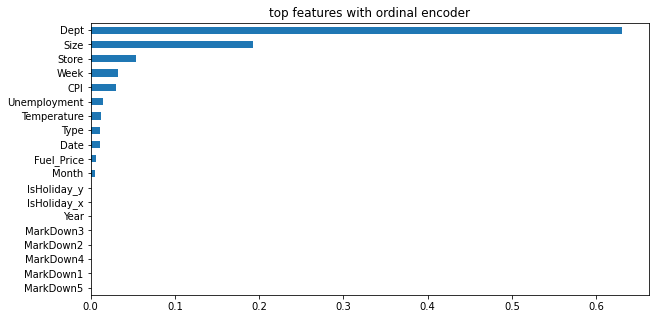

In [41]:
#특성 중요도 
rf = pipe2.named_steps['randomforestregressor']
importances=pd.Series(rf.feature_importances_,X_train.columns)

n=20
plt.figure(figsize=(10,n/4))
plt.title("top features with ordinal encoder")
importances.sort_values()[-n:].plot.barh();


xgb

In [34]:
#xgb
pipe5 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor()
)

pipe5.fit(X_train, y_train);
y_pred7=pipe5.predict(X_train)
y_val_pred7=pipe5.predict(X_val)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_pred7)), print("R2:",r2_score(y_train,y_pred7))
print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred7)), print("R2:",r2_score(y_val,y_val_pred7))

[07:23:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련데이터
MAE: 6737.478551790649
R2: 0.748580891206428
검증데이터
MAE: 7512.81368292179
R2: 0.6814064022066374


(None, None)

Random Forest hyper parameter tuning

In [35]:
#random forest hyper parameter tuning
def test_params(**params):  
  model=RandomForestRegressor(random_state=2,**params).fit(X_train_transformed,y_train)

  train_mae = mean_absolute_error(y_train,model.predict(X_train_transformed))
  #train_r2=r2_score(y_train,model.predict(X_train_transformed))
  val_mae= mean_absolute_error(y_val,model.predict(X_val_transformed))
  #val_r2=r2_score(y_val,model.predict(X_val_transformed))
  return train_mae,val_mae#,train_r2,val_r2

In [37]:
def test_param_and_plot(param_name, param_values):
    train_errors,val_errors = [],[]
    for value in param_values:
        params = {param_name: value}
        train_mae,val_mae= test_params(**params)
        train_errors.append(train_mae)
        val_errors.append(val_mae)

    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')

    plt.xlabel(param_name)
    plt.ylabel('MAE')
    plt.legend(['Training MAE', 'Validation MAE'])

In [ ]:
from sklearn.pipeline import Pipeline
pipe3 = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(),SimpleImputer())),
    ('rf', RandomForestRegressor(random_state=2)) 
])
pipe3.fit(X_train,y_train)

In [39]:
X_train_transformed=pipe3.named_steps['preprocessing'].transform(X_train)
X_val_transformed = pipe3.named_steps['preprocessing'].transform(X_val)

In [ ]:
#@title
#max depth에 대한  mae ->15
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

In [ ]:
def test_params(**params):  
  model=RandomForestRegressor(random_state=2,**params).fit(X_train_transformed,y_train)
  train_r2=r2_score(y_train,model.predict(X_train_transformed))
  val_r2=r2_score(y_val,model.predict(X_val_transformed))
  return train_r2,val_r2

In [ ]:
def test_param_and_plot_r2(param_name, param_values):
  train_r2,val_r2 = [],[]
    for value in param_values:
        params = {param_name: value}
        train_r2,val_r2= test_params(**params)
        train_r2.append(train_r2)
        val_r2.append(val_r2)

    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_r2, 'b--')
    plt.plot(param_values, val_r2, 'r--')

    plt.xlabel(param_name)
    plt.ylabel('MAE')
    plt.legend(['Training r2', 'Validation r2'])


In [ ]:
#max depth에 대한  r2
test_param_and_plot_r2('max_depth', [5, 10, 15, 20, 25, 30, 35])

최적 파라미터 적용 

In [45]:
# 최적 파라미터 (random forest)
pipe2_b=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(
        random_state=2,n_jobs=-1,max_depth=15,
        n_estimators=30,min_samples_split=10,
        min_samples_leaf=2,max_samples=0.8,max_features=7)
)

pipe2_b.fit(X_train,y_train)
y_pred5_b=pipe2_b.predict(X_train)
y_val_pred5_b=pipe2_b.predict(X_val)
y_test_pred=pipe2_b.predict(X_test)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_pred5_b)), print("R2:",r2_score(y_train,y_pred5_b))
print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred5_b)), print("R2:",r2_score(y_val,y_val_pred5_b))
print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred)), print("R2:",r2_score(y_test,y_test_pred))


훈련데이터
MAE: 4761.372948346921
R2: 0.8850795051164425
검증데이터
MAE: 6360.477601710252
R2: 0.7912685256164163
테스트데이터
MAE: 5405.979544187137
R2: 0.8552103497460093


(None, None)

In [47]:
#xgb (random forest)
pipe5_b = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(max_depth=10)
)

pipe5_b.fit(X_train, y_train);
y_pred7_b=pipe5_b.predict(X_train)
y_val_pred7_b=pipe5_b.predict(X_val)
y_test_pred=pipe5_b.predict(X_test)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_pred7_b)), print("R2:",r2_score(y_train,y_pred7_b))
print("검증데이터")
print("MAE:",mean_absolute_error(y_val,y_val_pred7_b)), print("R2:",r2_score(y_val,y_val_pred7_b))
print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred)), print("R2:",r2_score(y_test,y_test_pred))

[07:59:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련데이터
MAE: 1698.9029092889277
R2: 0.9827204462583953
검증데이터
MAE: 3232.84438381398
R2: 0.8800435861831531
테스트데이터
MAE: 2828.035434964004
R2: 0.9412306801688692


(None, None)

In [ ]:
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot

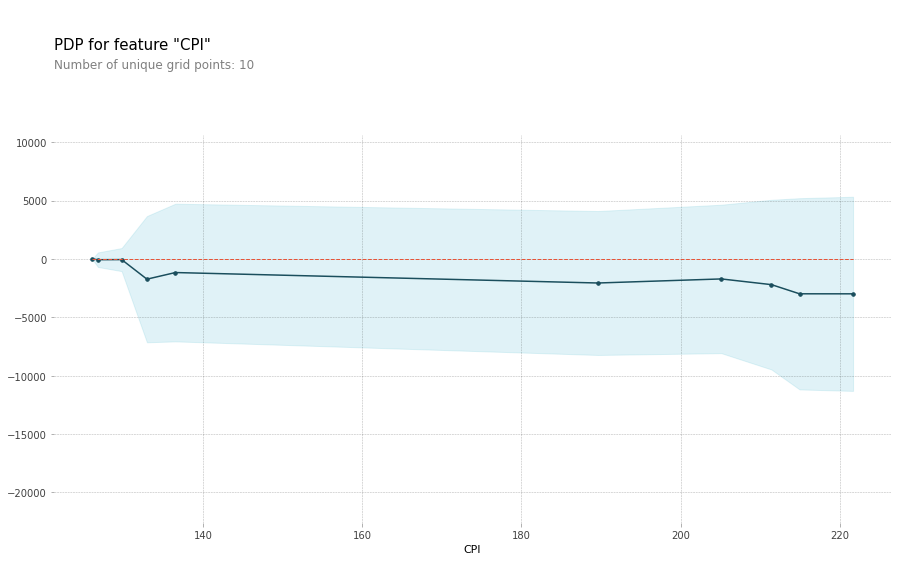

In [67]:
feature = 'CPI'

isolated = pdp_isolate(
    model=pipe5_b, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

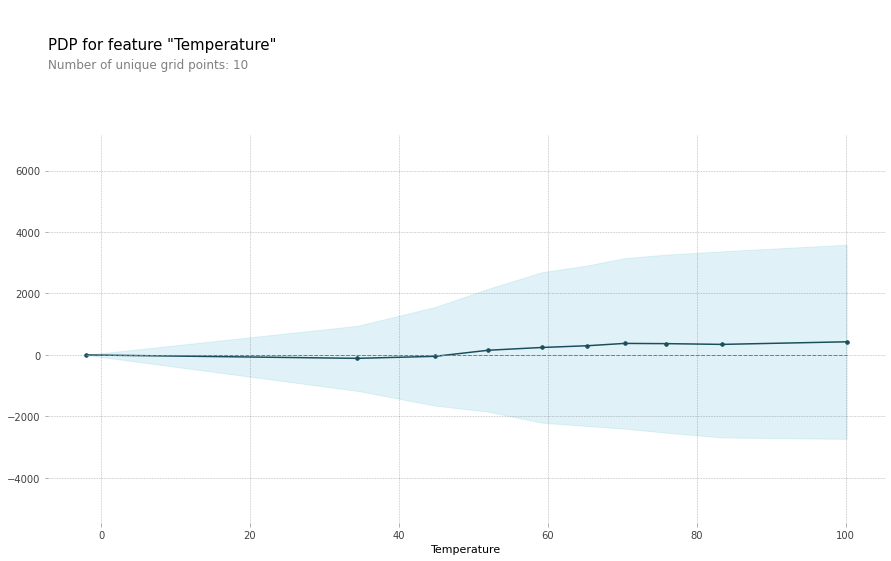

In [68]:
feature = 'Temperature'

isolated = pdp_isolate(
    model=pipe5_b, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

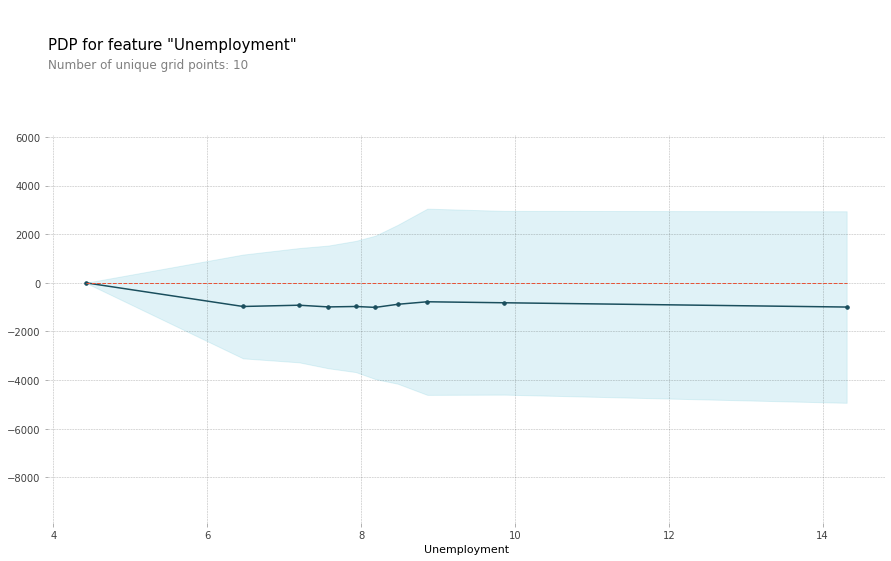

In [69]:
feature = 'Unemployment'

isolated = pdp_isolate(
    model=pipe5_b, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

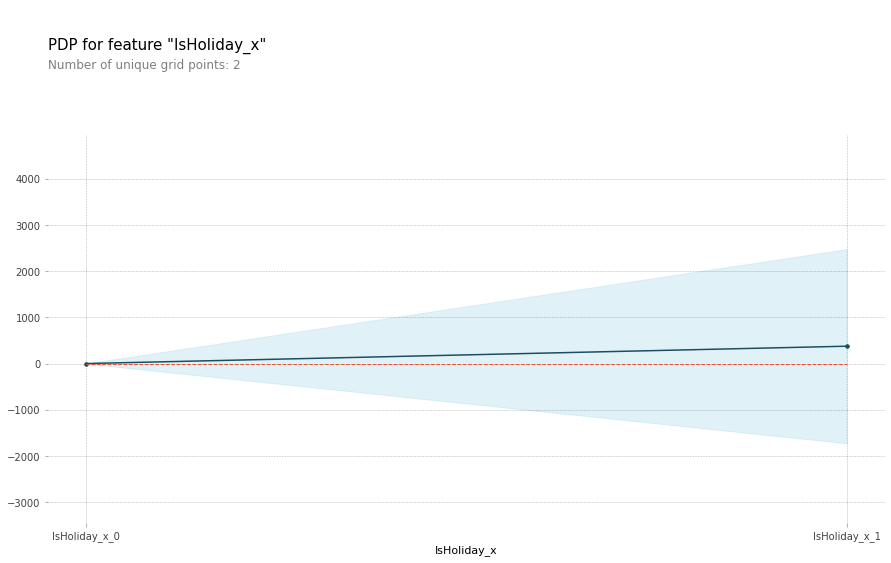

In [70]:
feature = 'IsHoliday_x'

isolated = pdp_isolate(
    model=pipe5_b, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

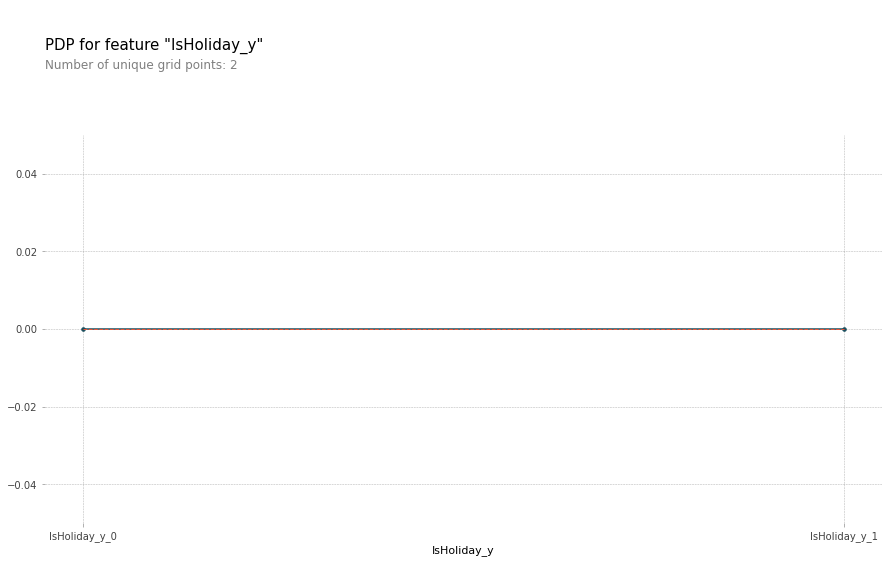

In [71]:
feature = 'IsHoliday_y'

isolated = pdp_isolate(
    model=pipe5_b, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

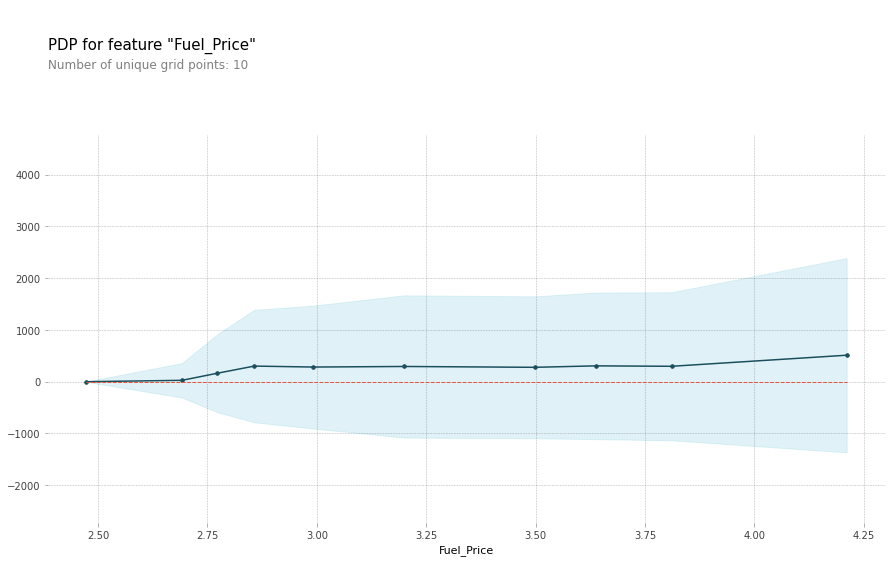

In [72]:
feature = 'Fuel_Price'

isolated = pdp_isolate(
    model=pipe5_b, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

결론

1. XGBOOST 모델로 예측시, 기존의 단순 과거 평균 치 예상보다 예측력이 높음

--> 기준 모델 테스트 데이터 MAE: 15043.35, R2: -1.92419
XGBOOST 모델 (하이퍼 파라미터 튜닝후) MAE: 2828.035,R2: 0.9412

2. 연도별 시기에 따라 비슷한 세일즈 트렌드가 존재함 

3. cpi, 실업률, 유가등 경제 지표의 영향력은 미미함 

추가 연구 필요한 점 

/Sales Data에 가장 큰 영향력을 끼치는 요소는 Dept로, 추후 우리 회사 진행 dept 만 따로 sorting 후 추가 분석 시 다른 변수에 대한 관계를 더 잘 볼 수 있어, 더욱 의미 있는 예측이 가능할 것으로 보임

/markdown 에 대한 결측치가 많아, 해당 데이터가 보완 후 더 의미 있는 분석 가능 할 것으로 보임 


